In [1]:
import pandas as pd
import numpy as np
from unicodedata import normalize
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import statsmodels.api as sm
from scipy import stats
import datetime
import plotly.express as px
pd.options.mode.chained_assignment = None  # default='warn'

Conect to Google Drive

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd drive/MyDrive/Pessoal/cafe

In [3]:
def remove_acento(y) :
    return normalize('NFKD', y).encode('ASCII','ignore').decode('ASCII').lower()

Raed data

In [4]:
df = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="BatchField Data")
df = df.astype(str)
df = df.applymap(remove_acento)

Read description of each column

In [5]:
descrip = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="Batch Field Descrip")
descrip.set_index('BatchFieldID', inplace=True)
descrip.sort_values(by = 'BatchFieldID')
#descrip

,Phase,Field,Definition
BatchFieldID,,,
1,Recepcion,Brix 1,Measurement of sucrose level in fruit at recep...
2,Recepcion,pH 1,Measurement of pH level at reception stage
3,Recepcion,Temperatura,Measurement of fruit temperature at reception ...
4,Recepcion,Calidad Tipo,Definition of quality type : quality A or qual...
5,Recepcion,Cereza Sana,Measurement of the healthy and ripe fruit
6,Recepcion,Pintones Maduros,Measurement of unripe fruit
7,Recepcion,Defectos,Measurement of overall defects in fruit received
8,Recepcion,Granos Vanos,Measurement of a particular defect in beans re...
9,Recepcion,Sobremaduros,Measurement of overripe beans at reception level


Pivot BatchFieldID values to columns

In [6]:
pivot_df = pd.pivot_table(df, columns = "BatchFieldID", index ="BatchID", values = "Value", aggfunc=lambda x: '-'.join(x))
pivot_df.index = pivot_df.index.astype(int)

Read SCA data

In [7]:
df_target = pd.read_excel("Batch Data_DEF.xlsx", sheet_name="Batchs")
df_target = df_target.rename({'Batchid': 'BatchID'}, axis=1)  # new method
df_target.set_index('BatchID', inplace=True)
df_target.index = df_target.index.astype(int)
#df_target

Merge SCA to variables data using BathchId

In [141]:
fdf = pd.merge(pivot_df, df_target, left_index=True, right_index=True)

In [142]:
fdf['CreationDate'] = pd.to_datetime(fdf['CreationDate'], format='%Y-%b-%d')

In [143]:
fdf['doy'] = fdf['CreationDate'].apply(lambda row: row.timetuple().tm_yday)

In [144]:
list_top_4=fdf.Variety.value_counts().sort_values(ascending=False).head(4).index

In [145]:
for category in fdf['Variety'].unique():
    fdf[category]=np.where(fdf['Variety']==category,1,0)

fdf['NATURAL']=np.where(fdf['Process']=='NATURAL',1,0)

Split data by dtype (datetime, string and numerical)

In [146]:
dt = [18,
19,
20,
21,
30,
31,
36,
37,
43,
44,
51,
52,
58, "Sca"]

dt = [str(x) for x in dt]

txt = [4,
10,
32,
35,
45,
50,
59,
61,
62,
63,
69,
70,
71,"Process","Program BatchCode", "Proces", "Variety", "Sca"]

txt = [str(x) for x in txt]

num = [1,
2,
3,
5,
6,
7,
8,
9,
22,
25,
26,
28,
29,
38,
39,
40,
41,
42,
56,
57,
60,
64,
65,
66,
67,
68, "YieldFactor","NetWeight", "Sca",'Castillo', 'Geisha', 'Mixed', 'Sidra', 'NATURAL', 'doy']

num = [str(x) for x in num]
dt_df = fdf[fdf.columns.intersection(dt)]
tx_df = fdf[fdf.columns.intersection(txt)]
nm_df = fdf[fdf.columns.intersection(num)].apply(pd.to_numeric)

Add variables to dt_df e nm_df

In [147]:
dt_df.iloc[:, :-1] = dt_df.iloc[:, :-1].apply(pd.to_datetime, errors='coerce')
#dt_df.dtypes
dt_df["51"] = pd.to_datetime(dt_df["51"], utc = True)
dt_df["52"] = pd.to_datetime(dt_df["52"], utc =True)
dt_df["delta_secado_mecanico"] = dt_df["52"] - dt_df["51"]
dt_df["delta_secado_natural"] = dt_df["44"] - dt_df["43"]
dt_df["delta_f_cb"] = dt_df["31"] - dt_df["30"]
dt_df["delta_f_cc"] = dt_df["19"] - dt_df["18"]
dt_df["delta_f_cc"] =  dt_df["delta_f_cc"] / np.timedelta64(1, 'h')
dt_df["delta_f_cb"] =  dt_df["delta_f_cb"] / np.timedelta64(1, 'h')
dt_df['delta_secado_natural'] =  dt_df['delta_secado_natural'] / np.timedelta64(1, 'h')
dt_df['delta_secado_mecanico'] =  dt_df['delta_secado_mecanico'] / np.timedelta64(1, 'h')

In [148]:
# nm_df["delta_t1"] = nm_df["3"] - nm_df["26"]
# nm_df["delta_t2"] = nm_df["26"] - nm_df["40"]

nm_df["delta_ph1"] = nm_df["2"] - nm_df["25"]
nm_df["delta_ph2"] = nm_df["39"] - nm_df["25"]

nm_df["delta_brix1"] = nm_df["1"] - nm_df["22"]
nm_df["delta_brix2"] = nm_df["38"] - nm_df["22"]

# nm_df["delta_u_natural"] = nm_df["60"] - nm_df["65"]
# nm_df["delta_u_mecanico"] = nm_df["60"] - nm_df["66"]

Merge numerical in DateTime dataframe to Numerical dataframe

In [149]:
parcial_dt_df = dt_df[["delta_secado_mecanico","delta_secado_natural","delta_f_cc","delta_f_cb"]]
nm_df = pd.merge(nm_df, parcial_dt_df, left_index=True, right_index=True)

In [151]:
nm_df.columns

Index(['1', '2', '22', '25', '26', '28', '29', '3', '38', '39', '40', '41',
       '42', '5', '56', '57', '6', '60', '64', '65', '66', '67', '68', '7',
       '8', '9', 'YieldFactor', 'Sca', 'NetWeight', 'doy', 'Sidra', 'Geisha',
       'Mixed', 'Castillo', 'NATURAL', 'delta_ph1', 'delta_ph2', 'delta_brix1',
       'delta_brix2', 'delta_secado_mecanico', 'delta_secado_natural',
       'delta_f_cc', 'delta_f_cb'],
      dtype='object')

In [152]:
nm_df.columns = ['brix1', 'ph1', 'despulpapado_brix', 'despulpado_ph', 'despulpado_t', 'despulpado_partidos',\
                 'despulpado_broca', 'temperatura', 'cl_brix', 'cl_ph', 'cl_t', 'cl_partidos',
       'cl_broca', 'cereza_sana', 'n_bultos', 'kg_amuestra', 'pintones_maduros', 'humedad', 't_masa',\
                 'humedad_final_natural', 'humedad_final_mecanico', 'rechazo_por_flote', 'rechazo_cafe_seco', 'defectos',
       'granos_vanos', 'sobremaduros', 'YieldFactor', 'Sca', 'NetWeight', 'doy', 'Sidra', 'Geisha',
       'Mixed', 'Castillo', 'NATURAL', 'delta_ph1', 'delta_ph2', 'delta_brix1',
       'delta_brix2', 'delta_secado_mecanico', 'delta_secado_natural',
       'delta_f_cc', 'delta_f_cb']

In [153]:
nm_df = nm_df[nm_df.Sca != 0]
#dataset.drop(['rechazo_por_flote', 'rechazo_cafe_seco'], axis=1, inplace=True)
#dataset = dataset.dropna()
perc =50.0 # Here N is 75
min_count =  int(((100-perc)/100)*nm_df.shape[1] + 1)
dataset = nm_df.dropna( axis=0, 
                    thresh=min_count)

In [154]:
df_sliced = nm_df.dropna(axis=1, thresh=int(0.5*len(nm_df)))
# perc =50.0 # Here N is 75
# min_count =  int(((100-perc)/100)*df_sliced.shape[1] + 1)
# dataset_sliced = df_sliced.dropna( axis=0, 
#                     thresh=min_count)

Assess numerical data quality

In [155]:
def get_num_outliers (column):
    q1 = nm_df[column].quantile(0.25)
    q3 = nm_df[column].quantile(0.75)
    return 1 - (sum((nm_df[column]<q1) | (nm_df[column]>q3))/nm_df[column].count())

def get_nan(column):
    c_nan = nm_df[column].isna().sum()
    c_nan = c_nan / len(fdf)
    return 1-c_nan

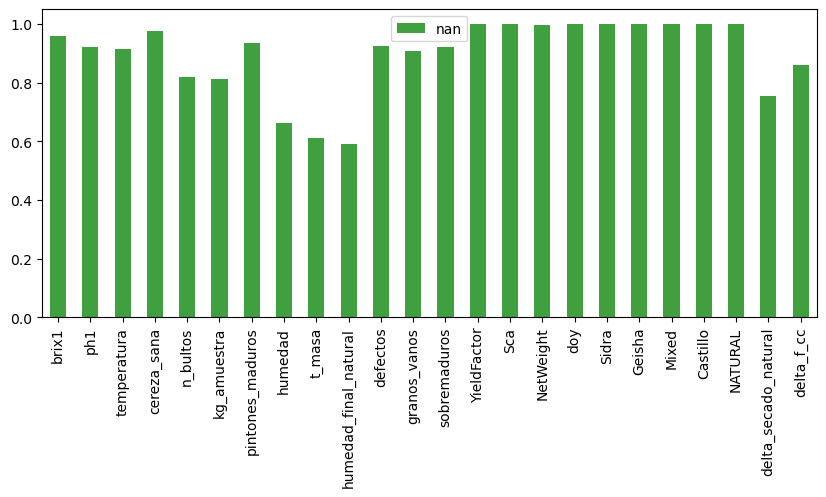

In [156]:
col = df_sliced.columns.to_frame().reset_index().drop(0, axis =1)
col["outliers"] = col.apply(lambda row : get_num_outliers(row["index"]), axis =1)
col["nan"] = col.apply(lambda row: get_nan(row["index"]), axis =1)
col["confidence"] = col["outliers"]*col["nan"]
col.set_index('index', inplace=True)
#col.index = col.index.astype(int)
descrip.index = descrip.index.map(str)
nan_count = pd.merge(descrip, col, left_index=True, right_index=True, how = "right")
#nan_count = nan_count.rename({0: 'nan_percentage'}, axis=1)  # new method
nan_count.sort_values(by = 'confidence')
nan_count.plot(kind ="bar",use_index = True, y='nan', rot=0, figsize=(10,4), alpha = 0.75, color = "green")
plt.xticks(rotation=90)
plt.xlabel("")
plt.show()
#nan_count.sort_values(by = 'confidence')

Numerical data histogram

Correlate numerical data to SCA

<AxesSubplot:title={'center':'Correlation with Sca'}>

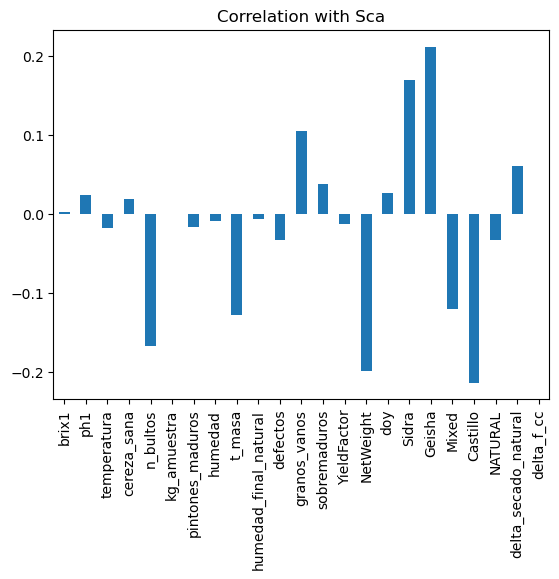

In [157]:
#plt.matshow(nm_df.corr()["Sca"])
#plt.show()
cor_df = df_sliced.corr()["Sca"]
cor_df = cor_df.drop("Sca")
cor_df.plot(kind = "bar", title = "Correlation with Sca")

DateTime Histogram

# Correlation between some variables to SCA

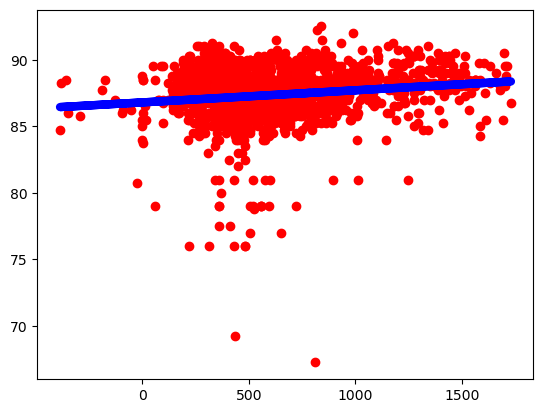

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     34.64
Date:                Tue, 31 Jan 2023   Prob (F-statistic):           4.85e-09
Time:                        14:50:43   Log-Likelihood:                -3367.8
No. Observations:                1564   AIC:                             6740.
Df Residuals:                    1562   BIC:                             6750.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         86.7946      0.108    800.014      0.0

In [33]:
subset = dt_df.loc[:, ["delta_secado_natural", 'Sca']]
#subset["28"].fillna(0, inplace=True)
subset = subset[subset["delta_secado_natural"].notna()]

#q_low = subset["6"].quantile(0.01)
#q_hi  = subset["6"].quantile(0.99)
#
#df_filtered = subset[(subset["6"] < q_hi) & (subset["6"] > q_low)]

df_filtered = subset[(np.abs(stats.zscore(subset)) < 1).all(axis=1)]

x = df_filtered["delta_secado_natural"].values.reshape(-1, 1)
y = df_filtered ["Sca"].values.reshape(-1, 1)

#subset
#regr = linear_model.LinearRegression()
#regr.fit(x, y)
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
#print(est2.summary())

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='red')
plt.plot(x, est2.predict(X), color='blue', linewidth=6)
#plt.xticks(range(min(x), max(x)+1))
#plt.yticks(range(int(min(y)), int(max(y))+1, 5))
plt.show()
print(est2.summary())

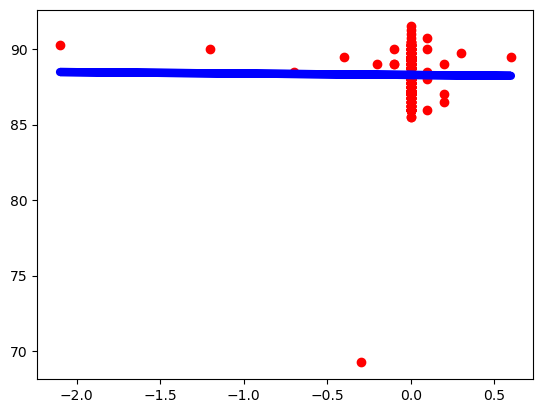

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.02331
Date:                Thu, 19 Jan 2023   Prob (F-statistic):              0.879
Time:                        18:09:37   Log-Likelihood:                -559.57
No. Observations:                 294   AIC:                             1123.
Df Residuals:                     292   BIC:                             1131.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.2898      0.095    927.263      0.0

In [19]:
subset = nm_df.loc[:, ["delta_u_mecanico", 'Sca']]
#subset["28"].fillna(0, inplace=True)
subset = subset[subset["delta_u_mecanico"].notna()]

#q_low = subset["6"].quantile(0.01)
#q_hi  = subset["6"].quantile(0.99)
#
#df_filtered = subset[(subset["6"] < q_hi) & (subset["6"] > q_low)]

df_filtered = subset[(np.abs(stats.zscore(subset)) < 1).all(axis=1)]

x = df_filtered["delta_u_mecanico"].values.reshape(-1, 1)
y = df_filtered ["Sca"].values.reshape(-1, 1)

#subset
#regr = linear_model.LinearRegression()
#regr.fit(x, y)
X = sm.add_constant(x)
est = sm.OLS(y, X)
est2 = est.fit()
#print(est2.summary())

# plot it as in the example at http://scikit-learn.org/
plt.scatter(x, y,  color='red')
plt.plot(x, est2.predict(X), color='blue', linewidth=6)
#plt.xticks(range(min(x), max(x)+1))
#plt.yticks(range(int(min(y)), int(max(y))+1, 5))
plt.show()
print(est2.summary())

## Find Batch Quality (average) by month

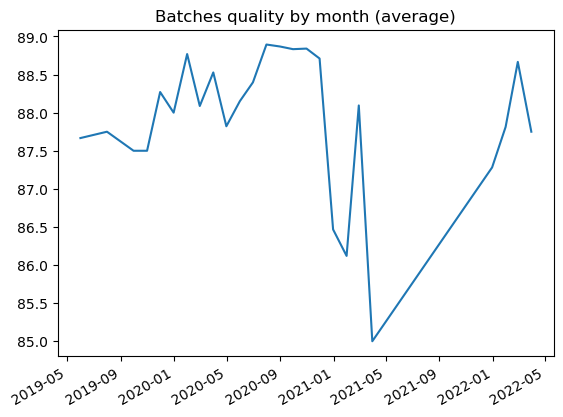

In [20]:
#cols = dt_df[["18", "19", "51", "52"]]
#dt_df[["18", "19", "51", "52"]] = dt_df[["18", "19", "51", "52"]].apply(pd.to_datetime, errors='coerce')
#dt_df[["18", "19", "51", "52"]]
#dt_df
#cols
#dt_df[["18", "19", "51", "52"]]= dt_df[["18", "19", "51", "52"]].apply(lambda t: t.tz_localize(None))
#dt_df[["18", "19", "51", "52"]] = pd.to_datetime(dt_df[["18", "19", "51", "52"]], unit='ms').dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
subset = dt_df.loc[:, ["18", 'Sca']]
subset["Sca"].replace(0, np.nan, inplace=True)
#subset["28"].fillna(0, inplace=True)
subset = subset[subset["Sca"].notna()]
subset = subset[subset["18"].notna()]
subset['18'] =  pd.to_datetime(subset['18'], utc=True)
subset = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
subset.set_index('18', inplace=True)
g = subset.groupby(pd.Grouper(freq='M'))["Sca"].mean().reset_index()
g = g[g["Sca"].notna()]


x = g["18"].values.reshape(-1, 1)# plot
y = g["Sca"].values.reshape(-1, 1)
plt.plot(x,y)
plt.title('Batches quality by month (average)')
# beautify the x-labels
plt.gcf().autofmt_xdate()

plt.show()

## Boxplot of categorical data

In [21]:
# txcol = tx_df.columns
# for item in txcol:
#     subset = tx_df.loc[:, [item, 'Sca']]
#     #subset["28"].fillna(0, inplace=True)
#     subset = subset[subset[item].notna()]
#     tx_filtered = subset[(np.abs(stats.zscore(subset["Sca"])) < 1)]
#     bp = sns.catplot(data=tx_filtered, y=item, x="Sca", kind="box", orient ="h", height=6,aspect=2).fig.suptitle(item + ' x SCA')

# Testing PCA

In [158]:
#dataset['cat'] = dataset['Sca'].round().astype(int)
toFill_df = df_sliced#.drop(['22', '25', '26', '28', '29', '38', '39', '40', '41', '42', '65', '66','67'], axis=1)

col_map = {toFill_df.columns.get_loc(col):col for col in toFill_df.columns} # {0: "col1", 1: "col2"}
median_values = pd.Series(np.nanmedian(toFill_df, axis=0)).rename(col_map)
filled_df = toFill_df.fillna(median_values)

In [160]:
filled_df.shape

(2226, 24)

In [161]:
PcaDataset = filled_df.drop(['Sca'], axis=1)
# Scale data before applying PCA
scaling=StandardScaler()
# Use fit and transform method
scaling.fit(PcaDataset)
data =scaling.transform(PcaDataset)
# Set the n_components=3

n_components= 15
principal=PCA(n_components=n_components)
principal.fit(data)
x=principal.transform(data)
#principal.explained_variance_ratio_.sum()
# Check the dimensions of data after PCA
#print(x.shape)

labels = {str(i): f"PC {i+1}" for i in range(n_components)}
labels['color'] = 'SCA'

fig = px.scatter_matrix(
    x,
    color=filled_df.Sca,
    dimensions=range(n_components),
    labels=labels,
    title=f'Total Explained Variance: {principal.explained_variance_ratio_.sum() * 100:.2f}%',
)
fig.update_traces(diagonal_visible=False)
fig.show()

In [162]:
columns = ['pca_comp_%i' % i for i in range(n_components)]
df_pca  = pd.DataFrame(x, columns=columns, index=PcaDataset.index)
df_pca = pd.merge(df_pca,filled_df[['Sca']],left_index=True, right_index=True)

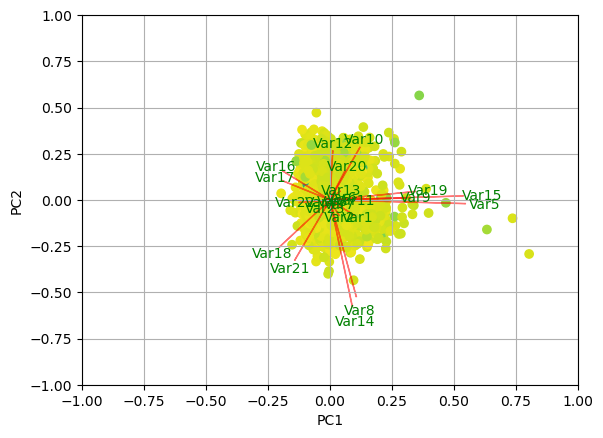

In [163]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = filled_df.Sca)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

#Call the function. Use only the 2 PCs.
myplot(x[:,0:2],np.transpose(principal.components_[0:2, :]))
plt.show()

In [164]:
n_pcs= principal.components_.shape[0]
range(n_pcs)

range(0, 15)

In [165]:
# principal.explained_variance_ratio_
# print(abs( principal.components_ ))

most_important = [np.abs(principal.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names =filled_df.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
mpc_df = pd.DataFrame(dic.items())
mpc_df

,0,1
0,PC0,n_bultos
1,PC1,YieldFactor
2,PC2,Mixed
3,PC3,doy
4,PC4,ph1
5,PC5,NATURAL
6,PC6,defectos
7,PC7,pintones_maduros
8,PC8,temperatura
9,PC9,kg_amuestra


## Test models training - Classification

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [167]:
def label_race (row):
    if row['Sca'] > 89 :
        return '0'
    elif row['Sca'] == 89 :
        return '1'
    elif row['Sca'] == 88 :
        return '2'
    elif row['Sca'] == 87 :
        return '3'
    elif row['Sca'] == 86 :
        return '4'
    elif row['Sca'] < 86 :
        return '5'

In [197]:
def border_class(row):
    if row['Sca'] > 87 :
        return 0
    else:
        return 1

In [198]:
filled_df['cat'] = filled_df.apply (lambda row: label_race(row.astype(int)), axis=1)
filled_df['border'] = filled_df.apply (lambda row: border_class(row), axis=1)

In [199]:
X = filled_df.drop(['border', 'cat', 'Sca'], axis = 1)
y = filled_df[['border']]

In [200]:
X_train, X_test, y_train, y_test= train_test_split(X,y, test_size= 0.25)

In [215]:
def classification_report_csv(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[2:-3]:
        row = {}
        row_data = line.split('      ')
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    dataframe = pd.DataFrame.from_dict(report_data)

# first, initialize the classificators
#tree= DecisionTreeClassifier(random_state=24) # using the random state for reproducibility
forest= RandomForestClassifier(random_state=24)
#knn= KNeighborsClassifier()
#svm= SVC(random_state=24)
#xboost= XGBClassifier(random_state=24)

# now, create a list with the objects 
models=[forest] #[tree, forest, knn, svm, xboost]

for model in models:
    model.fit(X_train, y_train) # fit the model
    y_pred= model.predict(X_test) # then predict on the test set
    accuracy= accuracy_score(y_test, y_pred) # this gives us how often the algorithm predicted correctly
    clf_report= classification_report(y_test, y_pred) # with the report, we have a bigger picture, with precision and recall for each class
    #cldf = clf_report.transpose()
    #clf_report
    print(f"The accuracy of model {type(model).__name__} is {accuracy:.2f}")
    print(clf_report)
    print("\n")

C:\Users\gabri\AppData\Local\Temp\ipykernel_111700\3319677668.py:26: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



The accuracy of model RandomForestClassifier is 0.81
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       338
           1       0.83      0.66      0.73       219

    accuracy                           0.81       557
   macro avg       0.82      0.78      0.79       557
weighted avg       0.81      0.81      0.81       557





In [213]:
importances= forest.feature_importances_
# def f_importances(coef, names):
#     imp = coef
#     imp,names = zip(*sorted(zip(imp,names)))
#     plt.barh(range(len(names)), imp, align='center')
#     plt.yticks(range(len(names)), names)
#     plt.show()

feature_names = [f"{i}" for i in X.columns]
# #features_names = ['input1', 'input2']
# #svm = svm.SVC(kernel='linear')
# #svm.fit(X, Y)
#f_importances(svm.coef_, features_names)

In [219]:
forest.n_outputs_

1

In [203]:
std = np.std([forest.feature_importances_ for forest in forest.estimators_], axis=0)

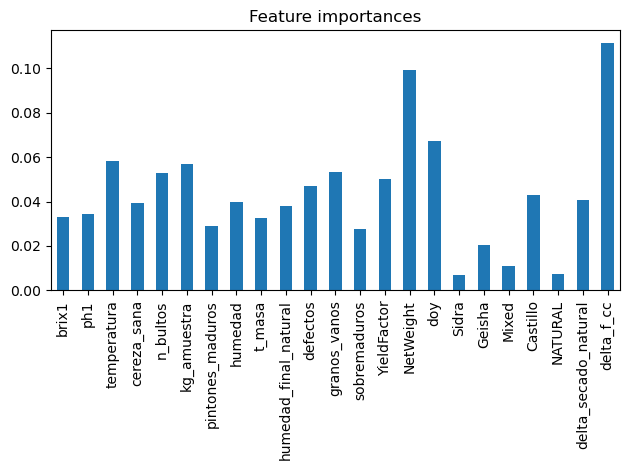

In [204]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances")
#ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Test models training - Classification

In [ ]:
# Test models training - Classification

In [ ]:
!jupyter nbconvert --to html relatorio_research.ipynb --no-input --execute